In [14]:
!pip install yfinance

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

## Data Acquisition: Download historical data for the specified symbol within the provided date range.

In [16]:
df = yf.download(
    "AAPL",
    start="2018-01-01",
    end="2023-12-31",
    progress=False
)

# flatten column levels converting multi-index to single index
df.columns = ['_'.join(col).strip() for col in df.columns.values]

print("DataFrame columns after flattening to combined levels:")
print(df.columns)

df.head()

DataFrame columns after flattening to combined levels:
Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')


/tmp/ipython-input-1980906703.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2018-01-02,40.341888,40.351258,39.639313,39.850088,102223600
2018-01-03,40.334858,40.878185,40.271629,40.405116,118071600
2018-01-04,40.522217,40.625262,40.299735,40.407462,89738400
2018-01-05,40.983570,41.070220,40.526897,40.618231,94640000
2018-01-08,40.831352,41.126433,40.732989,40.831352,82271200


## Data Cleanup: Filter out duplicate data points and handle NaN values by forward filling.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_AAPL   1509 non-null   float64
 1   High_AAPL    1509 non-null   float64
 2   Low_AAPL     1509 non-null   float64
 3   Open_AAPL    1509 non-null   float64
 4   Volume_AAPL  1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.7 KB


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close_AAPL,1509.0,1.078244e+02,5.093409e+01,3.379968e+01,5.123743e+01,1.204647e+02,1.502208e+02,1.962566e+02
High_AAPL,1509.0,1.089520e+02,5.140790e+01,3.463879e+01,5.204045e+01,1.217188e+02,1.519725e+02,1.977524e+02
Low_AAPL,1509.0,1.065843e+02,5.040656e+01,3.375451e+01,5.085842e+01,1.189656e+02,1.482232e+02,1.951570e+02
Open_AAPL,1509.0,1.077245e+02,5.089312e+01,3.422517e+01,5.137482e+01,1.206055e+02,1.500464e+02,1.961674e+02
Volume_AAPL,1509.0,1.073284e+08,5.513287e+07,2.404830e+07,7.078370e+07,9.296430e+07,1.280440e+08,4.265100e+08


In [19]:
df = df[~df.index.duplicated()]

# forward fill NaN values
df.ffill(inplace=True)

df.isna().sum()

,0
Close_AAPL,0
High_AAPL,0
Low_AAPL,0
Open_AAPL,0
Volume_AAPL,0


## Analytical Insights: Compute the moving averages for 50 and 200 days.

In [20]:
df["MA_50"] = df["Close_AAPL"].rolling(window=50).mean()
df["MA_200"] = df["Close_AAPL"].rolling(window=200).mean()

df.tail()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,MA_50,MA_200
Date,,,,,,,
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600,183.572858,176.609047
2023-12-26,191.243896,192.076034,191.025954,191.798655,28919300,183.858863,176.832685
2023-12-27,191.342957,191.689688,189.302232,190.689143,48087700,184.149422,177.047099
2023-12-28,191.768936,192.838834,191.362768,192.323695,34049900,184.479565,177.253185
2023-12-29,190.728775,192.581275,189.936256,192.085953,42672100,184.814827,177.452097


## Golden Opportunity: Identify the golden cross, signaling a bullish trend, and take a buying position.

In [21]:
initial_capital = 5000
capital = initial_capital

position = 0          # here, 0 = no position, 1 = holding
buy_price = 0
shares = 0
total_profit = 0

df["Buy_Signal"] = False
df["Sell_Signal"] = False

print(f"Initial Capital: ${capital:.2f}")

Initial Capital: $5000.00


In [22]:
for i in range(1, len(df)):
    prev_row = df.iloc[i - 1]
    curr_row = df.iloc[i]

    # BUY: golden cross
    if (
        prev_row["MA_50"] < prev_row["MA_200"]
        and curr_row["MA_50"] > curr_row["MA_200"]
        and position == 0
    ):
        buy_price = curr_row["Close_AAPL"]
        shares = int(capital // buy_price)
        position = 1
        df.iloc[i, df.columns.get_loc("Buy_Signal")] = True

        print(f"BUY {shares} shares at ${buy_price:.2f}")

    # SELL: death cross
    elif (
        prev_row["MA_50"] > prev_row["MA_200"]
        and curr_row["MA_50"] < curr_row["MA_200"]
        and position == 1
    ):
        sell_price = curr_row["Close_AAPL"]
        profit = (sell_price - buy_price) * shares
        total_profit += profit
        position = 0
        df.iloc[i, df.columns.get_loc("Sell_Signal")] = True

        print(f"SELL at ${sell_price:.2f} | Profit: ${profit:.2f}")

BUY 100 shares at $49.77
SELL at $142.78 | Profit: $9301.40
BUY 33 shares at $148.28
SELL at $137.78 | Profit: $-346.63
BUY 32 shares at $155.72


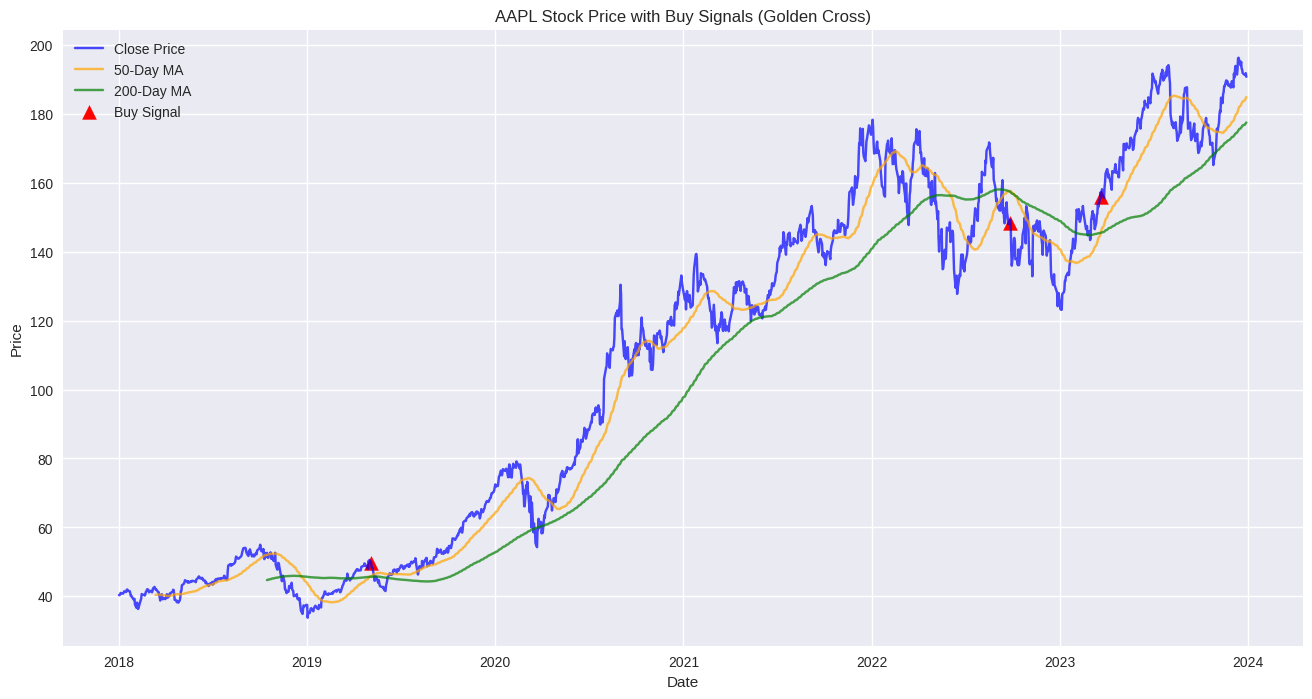

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close_AAPL'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['MA_50'], label='50-Day MA', color='orange', alpha=0.7)
plt.plot(df['MA_200'], label='200-Day MA', color='green', alpha=0.7)

buy_signals = df[df['Buy_Signal'] == True]
plt.scatter(
    buy_signals.index,
    buy_signals['Close_AAPL'],
    marker='^',
    color='red',
    s=100,
    label='Buy Signal',
    alpha=1
)

plt.title('AAPL Stock Price with Buy Signals (Golden Cross)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
if position == 1:
    final_price = df.iloc[-1]["Close_AAPL"]
    profit = (final_price - buy_price) * shares
    total_profit += profit
    df.iloc[-1, df.columns.get_loc("Sell_Signal")] = True

    print(f"FORCE SELL at ${final_price:.2f} | Profit: ${profit:.2f}")

FORCE SELL at $190.73 | Profit: $1120.23


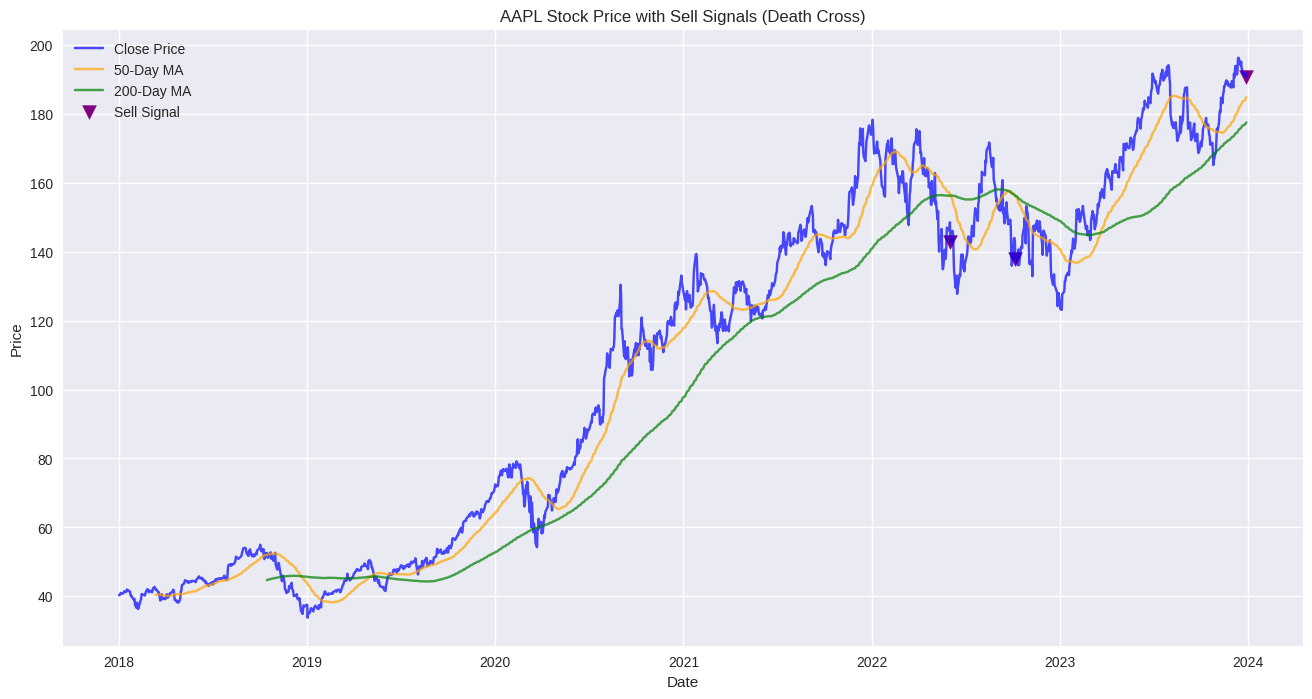

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close_AAPL'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['MA_50'], label='50-Day MA', color='orange', alpha=0.7)
plt.plot(df['MA_200'], label='200-Day MA', color='green', alpha=0.7)

sell_signals = df[df['Sell_Signal'] == True]
plt.scatter(
    sell_signals.index,
    sell_signals['Close_AAPL'],
    marker='v',
    color='purple',
    s=100,
    label='Sell Signal',
    alpha=1
)

plt.title('AAPL Stock Price with Sell Signals (Death Cross)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
print("\n--- Strategy Evaluation ---")
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Total Profit / Loss: ${total_profit:.2f}")
print(f"Final Portfolio Value: ${initial_capital + total_profit:.2f}")


--- Strategy Evaluation ---
Initial Capital: $5000.00
Total Profit / Loss: $10074.99
Final Portfolio Value: $15074.99
